<a href="https://colab.research.google.com/github/endyleon/song-detecting/blob/master/detection_startSong_endSong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install librosa
!pip install auditok
!pip install scipy
!pip install pydub
!pip install joblib
!apt install ffmpeg


In [0]:
!ffmpeg

In [0]:
import wave
import pickle
import numpy as np
#import ffmpeg
import librosa
from sklearn.mixture import GaussianMixture as GMM
from auditok import DataValidator, ADSFactory, DataSource, StreamTokenizer, BufferAudioSource, player_for
from pydub import AudioSegment
from pydub.utils import which

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
!ls "/content/drive/My Drive/app"

Chromaprint_proof.ipynb  detection_startSong_endSong.ipynb
data-audios		 Proof_colab_gpu.ipynb


In [0]:
def extract_mfcc(signal, sr=16000, n_mfcc=16, n_fft=256, hop_length=128, n_mels = 40, delta_1 = False, delta_2 = False):
    
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    if not (delta_1 or delta_2):
        return mfcc.T
    
    feat = [mfcc]
    
    if delta_1:
        mfcc_delta_1 = librosa.feature.delta(mfcc, order=1)
        feat.append(mfcc_delta_1)
    
    if delta_2:
        mfcc_delta_2 = librosa.feature.delta(mfcc, order=2)
        feat.append(mfcc_delta_2)
        
    return np.vstack(feat).T


def file_to_mfcc(filename, sr=16000, **kwargs):
    
    signal, sr = librosa.load(filename, sr = sr)
    
    return extract_mfcc(signal, sr, **kwargs)

In [0]:
class GMMClassifier():
    
    def __init__(self, models):
        """
        models is a dictionary: {"class_of_sound" : GMM_model_for_that_class, ...}
        """        
        self.models = models
    
    def predict(self, data):
        
        result = []
        for cls in self.models:
            
            llk = self.models[cls].score_samples(data)[0]
            llk = np.sum(llk)
            result.append((cls, llk)) 
        
        """
        return classification result as a sorted list of tuples ("class_of_sound", log_likelihood)
        best class is the first element in the list
        """
        return sorted(result, key=lambda f: - f[1])

In [0]:
class ClassifierValidator(DataValidator):
    
    def __init__(self, classifier, target):
        """
        classifier: a GMMClassifier object
        target: string
        """
        self.classifier = classifier
        self.target = target
        
    def is_valid(self, data):
        
        r = self.classifier.predict(data)
        return r[0][0] == self.target

In [0]:
class VectorDataSource(DataSource):
     
    def __init__(self, data, scope=0):
        self.scope = scope
        self._data = data
        self._current = 0
    
    def read(self):
        if self._current >= len(self._data):
            return None
        
        start = self._current - self.scope
        if start < 0:
            start = 0
            
        end = self._current + self.scope + 1
        
        self._current += 1
        return self._data[start : end]
    
    def set_scope(self, scope):
        self.scope = scope
            
    def rewind(self):
        self._current = 0

In [0]:
"""
Size of audio window for which MFCC coefficients are calculated
"""
ANALYSIS_WINDOW = 0.02 # 0.02 second = 20 ms

"""
Step of ANALYSIS_WINDOW 
"""
ANALYSIS_STEP = 0.01 # 0.01 second overlap between consecutive windows

"""
number of vectors around the current vector to return.
This will cause VectorDataSource.read() method to return
a sequence of (SCOPE_LENGTH * 2 + 1) vectors (if enough
data is available), with the current vetor in the middle
"""
SCOPE_LENGTH = 10

"""
Number of Mel filters
"""
MEL_FILTERS = 40

"""
Number of MFCC coefficients to keep
"""
N_MFCC = 16

"""
Sampling rate of audio data
"""
SAMPLING_RATE = 16000

"""
ANALYSIS_WINDOW and ANALYSIS_STEP as number of samples
"""
BLOCK_SIZE = int(SAMPLING_RATE * ANALYSIS_WINDOW)
HOP_SIZE = int(SAMPLING_RATE * ANALYSIS_STEP)

"""
Compute delta and delta-delta of MFCC coefficients ?
"""
DELTA_1 = True
DELTA_2 = True

"""
Where to find data

/content/drive/
"""
PREFIX_TRAINING = "/content/drive/My Drive/app/data-audios/data_/train_/"
PREFIX_AUDIO_BLOCK = "/content/drive/My Drive/app/data-audios/audio-block/"

In [11]:
train_data = {}
train_data["start"] = ["ini_1.wav", "ini_2.wav", "ini_3.wav", "ini_4.wav", "ini_5.wav", "ini_6.wav", "ini_7.wav", "ini_8.wav", "ini_9.wav", "ini_10.wav", "ini_11.wav", "ini_12.wav", "ini_13.wav", "ini_14.wav", "ini_15.wav", "ini_16.wav"]
train_data["end"]  = ["end_1.wav", "end_2.wav", "end_3.wav", "end_4.wav", "end_5.wav", "end_6.wav", "end_7.wav", "end_8.wav", "end_9.wav", "end_10.wav", "end_11.wav", "end_12.wav", "end_13.wav", "end_14.wav", "end_15.wav"]
#train_data["middle"]  = ["midd_1.wav", "midd_2.wav", "midd_3.wav", "midd_4.wav", "midd_5.wav"]


models = {}

# build models
for cls in train_data:

    data = []
    for fname in train_data[cls]:
        data.append(file_to_mfcc(PREFIX_TRAINING + fname, sr=16000, n_mfcc=N_MFCC, n_fft=BLOCK_SIZE, hop_length=HOP_SIZE, n_mels=MEL_FILTERS, delta_1=DELTA_1, delta_2=DELTA_2))

    data = np.vstack(data)
    
    print("Class '{0}': {1} training vectors".format(cls, data.shape[0]))

    mod = GMM(n_components=10)
    mod.fit(data)
    models[cls] = mod

gmm_classifier = GMMClassifier(models)

# create a validator for each sound class
start_validator = ClassifierValidator(gmm_classifier,"start")
end_validator = ClassifierValidator(gmm_classifier, "end")
#middle_validator = ClassifierValidator(gmm_classifier, "middle")

Class 'start': 16016 training vectors
Class 'end': 15015 training vectors


In [12]:
!ls "/content/drive/My Drive/app/data-audios/audio-block"

cheat-codes-feels-great-ft-fetty-wap-cvbz-official-video.mp3
lisandro-cuxi-danser.mp3
lisandro-cuxi-danser.wav
louis-tomlinson-back-to-you-official-video-ft-bebe-rexha-digital-farm-animals.mp3
taylor-swift-look-what-you-made-me-do.mp3
taylor-swift-look-what-you-made-me-do.wav


In [13]:
name_sound = '/content/drive/My Drive/app/data-audios/audio-block/taylor-swift-look-what-you-made-me-do.wav'
name_sound_mp3 = '/content/drive/My Drive/app/data-audios/audio-block/taylor-swift-look-what-you-made-me-do.mp3'
AudioSegment.converter =which('ffmpeg')
sound = AudioSegment.from_file(name_sound_mp3, format = 'mp3')
sound.export(name_sound, format = 'wav')

<_io.BufferedRandom name='/content/drive/My Drive/app/data-audios/audio-block/taylor-swift-look-what-you-made-me-do.wav'>

In [0]:
# transform audio stream to be analyzed into a sequence of MFCC vectors
# create a DataSource object using MFCC vectors
#name_sound = PREFIX_AUDIO_BLOCK + 'louis-tomlinson-back-to-you-official-video-ft-bebe-rexha-digital-farm-animals.wav'
mfcc_data_source = VectorDataSource(data=file_to_mfcc(name_sound,
                                                      sr=16000, n_mfcc=N_MFCC,
                                                      n_fft=BLOCK_SIZE, hop_length=HOP_SIZE,
                                                      n_mels=MEL_FILTERS, delta_1=DELTA_1,
                                                      delta_2=DELTA_2), scope=SCOPE_LENGTH)

In [0]:
# create a tokenizer
analysis_window_per_second = 1. / ANALYSIS_STEP

min_seg_length = 0.5 # second, min length of an accepted audio segment
max_seg_length = 10 # seconds, max length of an accepted audio segment
max_silence = 0.3 # second, max length tolerated of tolerated continuous signal that's not from the same class

tokenizer = StreamTokenizer(validator=start_validator, min_length=int(min_seg_length * analysis_window_per_second),
                                max_length=int(max_seg_length * analysis_window_per_second),
                                max_continuous_silence= max_silence * analysis_window_per_second,
                                mode = StreamTokenizer.DROP_TRAILING_SILENCE)

In [0]:
# read all audio data from stream
wfp = wave.open(name_sound)
audio_data = wfp.readframes(-1)
width = wfp.getsampwidth()
wfp.close()

# data as numpy array will be used to plot signal
fmt = {1: np.int8 , 2: np.int16, 4: np.int32}
signal = np.array(np.frombuffer(audio_data, dtype=fmt[width]), dtype=np.float64)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 20, 10

def plot_signal_and_segmentation(signal, sampling_rate, segments=[]):
    _time = np.arange(0., np.ceil(float(len(signal))) / sampling_rate, 1./sampling_rate )
    if len(_time) > len(signal):
        _time = _time[: len(signal) - len(_time)]
    
    pylab.subplot(211)

    for seg in segments:
        
        fc = seg.get("fc", "g")
        ec = seg.get("ec", "b")
        lw = seg.get("lw", 2)
        alpha = seg.get("alpha", 0.4)
        
        ts = seg["timestamps"]
        
        # plot first segmentation outside loop to show one single legend for this class
        p = pylab.axvspan(ts[0][0], ts[0][1], fc=fc, ec=ec, lw=lw, alpha=alpha, label = seg.get("title", ""))
        
        for start, end in ts[1:]:
            p = pylab.axvspan(start, end, fc=fc, ec=ec, lw=lw, alpha=alpha)
            
            
    pylab.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
            borderaxespad=0., fontsize=22, ncol=2)
    
    pylab.plot(_time, signal)
    
    pylab.xlabel("Time (s)", fontsize=22)
    pylab.ylabel("Signal Amplitude", fontsize=22)
    pylab.show()

In [0]:
tokenizer = StreamTokenizer(validator=end_validator, min_length= int(0.5 * analysis_window_per_second),
                                max_length=int(10 * analysis_window_per_second),
                                max_continuous_silence= 0.3 * analysis_window_per_second,
                                mode = StreamTokenizer.DROP_TRAILING_SILENCE)
#tokenizer.validator = end_validator
mfcc_data_source.rewind()
mfcc_data_source.scope = 0
tokens = tokenizer.tokenize(mfcc_data_source)
ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]

seg = {"fc" : "g", "ec" : "g", "lw" : 0, "alpha" : 0.8, "title" : "End (auto)", "timestamps" : ts}

plot_signal_and_segmentation(signal, SAMPLING_RATE, [seg])

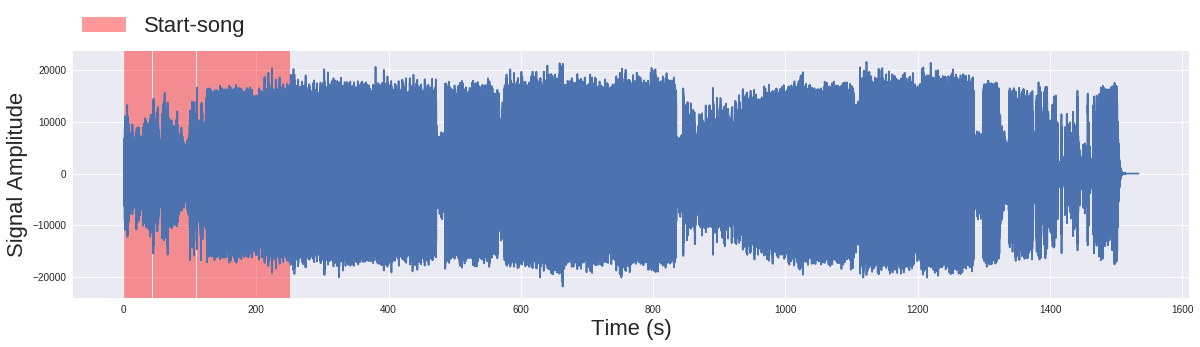

In [18]:
segments = []
mfcc_data_source.scope = 25

#Start    
mfcc_data_source.rewind()
tokenizer.validator = start_validator
tokens = tokenizer.tokenize(mfcc_data_source)
start_ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc":"r", "ec":"r", "lw":0, "alpha":0.4, "title":"Start-song", "timestamps":start_ts }
segments.append(seg)

'''
#End
mfcc_data_source.rewind()
tokenizer.validator = end_validator
tokens = tokenizer.tokenize(mfcc_data_source)
end_ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc":"m", "ec":"m", "lw":0, "alpha":0.4, "title":"End-song", "timestamps":end_ts }
segments.append(seg)
''' 

plot_signal_and_segmentation(signal, SAMPLING_RATE, segments)

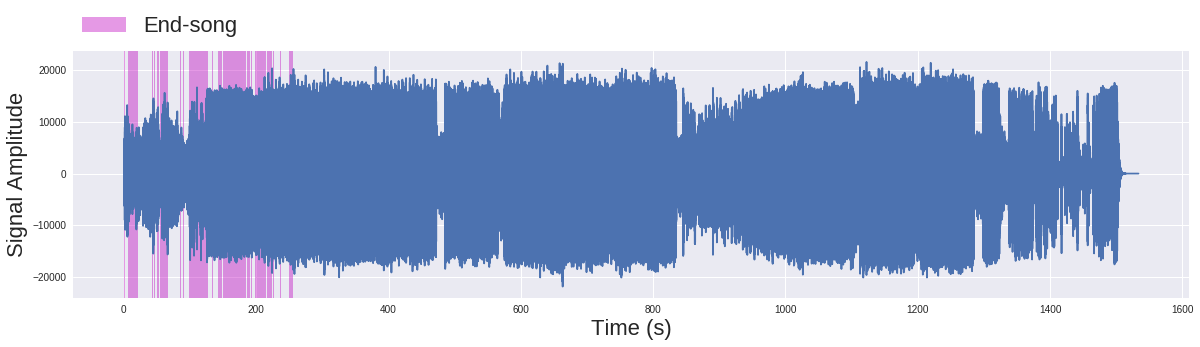

In [22]:
segments = []
mfcc_data_source.scope = 25

#End
mfcc_data_source.rewind()
tokenizer.validator = end_validator
tokens = tokenizer.tokenize(mfcc_data_source)
end_ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc":"m", "ec":"m", "lw":0, "alpha":0.4, "title":"End-song", "timestamps":end_ts }
segments.append(seg)

plot_signal_and_segmentation(signal, SAMPLING_RATE, segments)

In [0]:
''' 
segments = []
mfcc_data_source.scope = 25

#Middle
mfcc_data_source.rewind()
tokenizer.validator = middle_validator
tokens = tokenizer.tokenize(mfcc_data_source)
mid_ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc":"g", "ec":"g", "lw":0, "alpha":0.3, "title":"Middle-song", "timestamps":mid_ts }
segments.append(seg)


plot_signal_and_segmentation(signal, SAMPLING_RATE, segments)
'''